<a href="https://colab.research.google.com/github/LeToyek/production-ocr/blob/main/OCR_Production.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install Flask pytesseract opencv-python Pillow numpy scipy


In [3]:
!pip install pytesseract
!sudo apt install tesseract-ocr

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 45 not upgraded.
Need to get 4,816 kB of archives.
After this operation, 15.6 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-eng all 1:4.00~git30-7274cfa-1.1 [1,591 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-osd all 1:4.00~git30-7274cfa-1.1 [2,990 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr amd64 4.1.1-2.1build1 [236 kB]
Fetched 4,816 kB in 1s (3,436 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debc

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


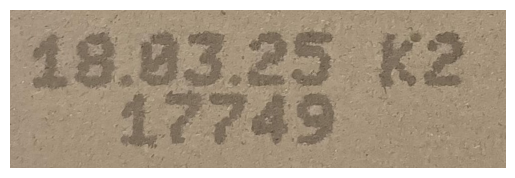

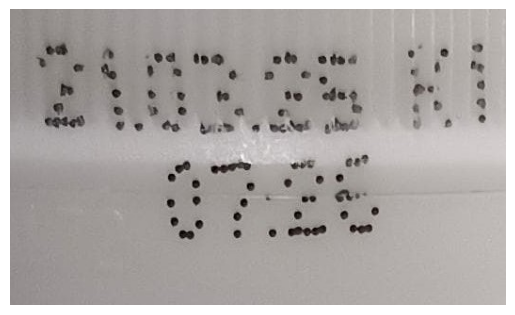

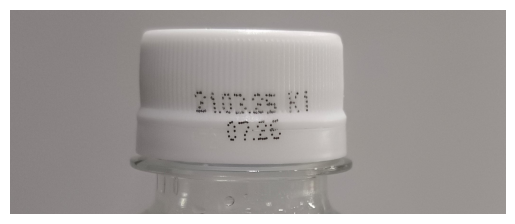

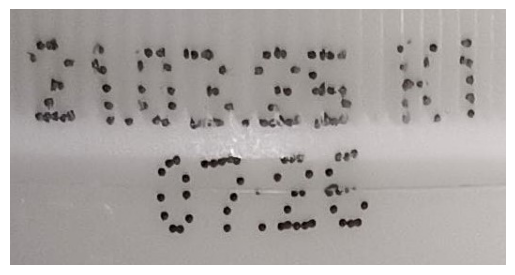

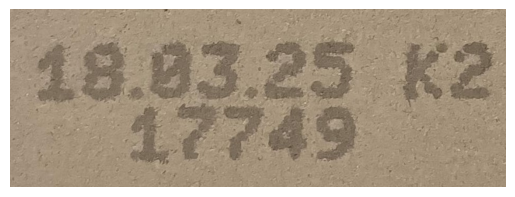

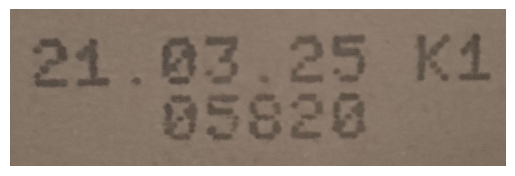

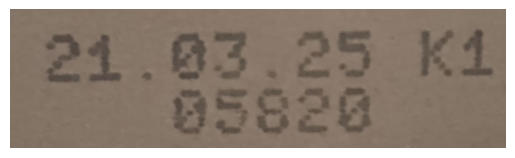

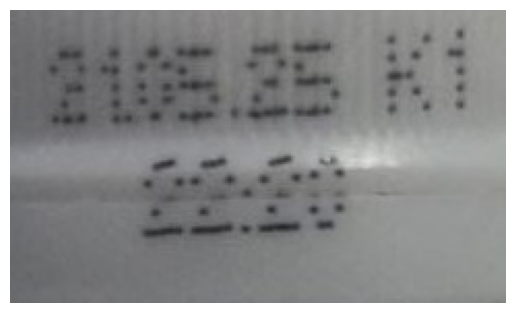

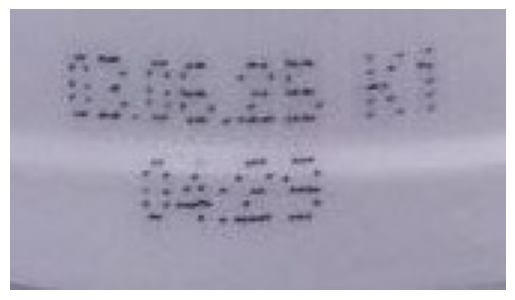

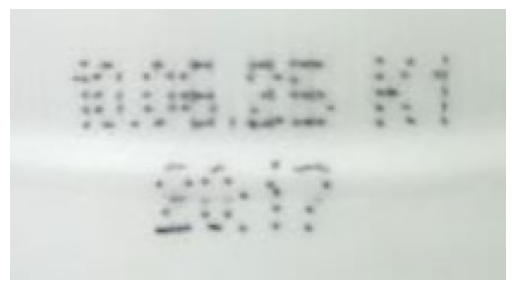

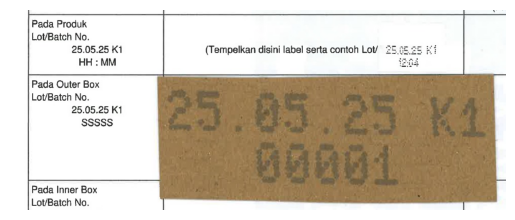

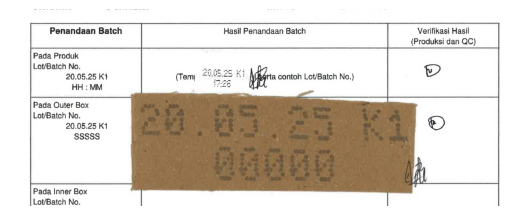

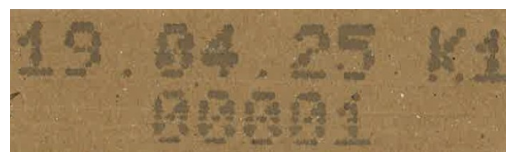

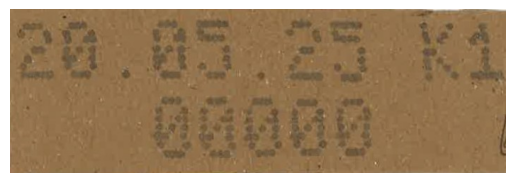

In [5]:
import os
import cv2
import matplotlib.pyplot as plt

# Define the path to your photos folder
photos_path = '/content/drive/MyDrive/production-ocr-dataset/'

# List all files in the folder
photo_files = [f for f in os.listdir(photos_path) if os.path.isfile(os.path.join(photos_path, f))]

# Function to display an image
def display_image(image_path):
    # Read the image using OpenCV
    img = cv2.imread(image_path)
    # Convert BGR to RGB for displaying with matplotlib
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    # Display the image
    plt.imshow(img_rgb)
    plt.axis('off')
    plt.show()

# Display each photo
for photo in photo_files:
    photo_path = os.path.join(photos_path, photo)
    display_image(photo_path)


In [6]:
def psnr(original, processed):
    mse = np.mean((original - processed) ** 2)
    if mse == 0:  # MSE is zero means no noise is present in the signal
        return 100
    max_pixel = 255.0
    psnr_value = 20 * np.log10(max_pixel / np.sqrt(mse))
    return psnr_value

In [7]:
import time

import cv2
import numpy as np
import pytesseract
from matplotlib import pyplot as plt
from scipy.ndimage import interpolation as inter
from pytesseract import Output

# Localization

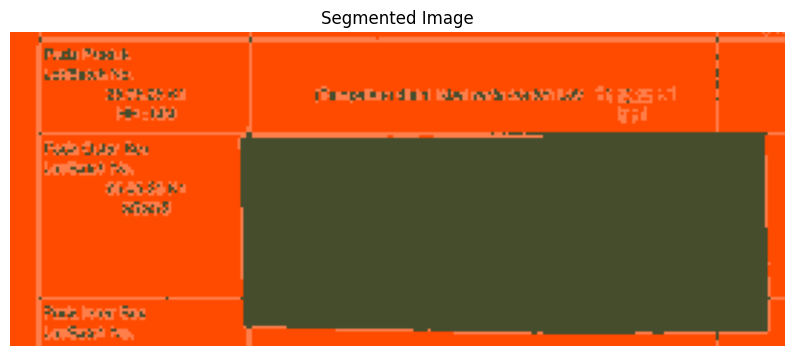

In [8]:
image = cv2.imread(os.path.join(photos_path, 'raw-kardus-5.jpeg'), cv2.IMREAD_GRAYSCALE)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image_lab = cv2.imread(os.path.join(photos_path, 'raw-kardus-5.jpeg'),cv2.COLOR_BGR2Lab)
# Reshape the image to a 2D array of Lab pixels
pixel_values = image_lab.reshape((-1, 3))

# Convert to float
pixel_values = np.float32(pixel_values)

# Define criteria and apply KMeans
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.2)
k = 3
_, labels, (centers) = cv2.kmeans(pixel_values, k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)

# Convert centers to 8 bit values
centers = np.uint8(centers)

# Map the labels to the centers
segmented_image = centers[labels.flatten()]
segmented_image = segmented_image.reshape(image_lab.shape)

# Convert back to RGB for displaying
segmented_image_rgb = cv2.cvtColor(segmented_image, cv2.COLOR_Lab2RGB)

# Show the segmented image
plt.figure(figsize=(10, 10))
plt.imshow(segmented_image_rgb)
plt.title("Segmented Image")
plt.axis('off')
plt.show()


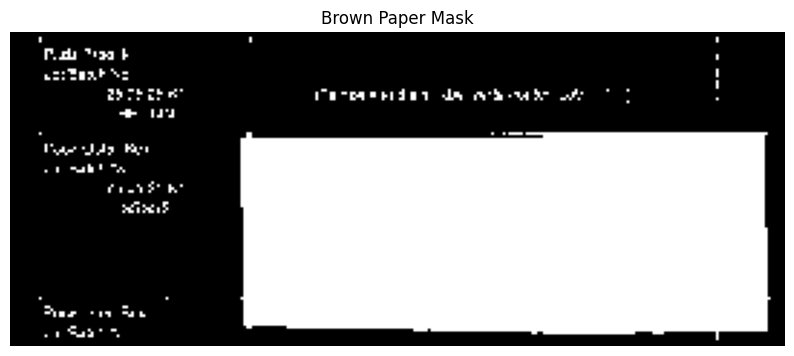

In [9]:


# Reshape the labels back to the original image shape
labels = labels.reshape(image_lab.shape[:2])

# Get the cluster centers in Lab color space
centers_lab = centers

# Identify the cluster for the brown paper
# (This may require manual inspection or heuristics based on cluster centers)
brown_cluster = np.argmin(np.linalg.norm(centers_lab - [160, 120, 120], axis=1))  # Example heuristic

# Create a mask for the brown paper
mask = np.zeros(labels.shape, dtype=np.uint8)
mask[labels == brown_cluster] = 255

# # Show the mask
plt.figure(figsize=(10, 10))
plt.imshow(mask, cmap='gray')
plt.title("Brown Paper Mask")
plt.axis('off')
plt.show()





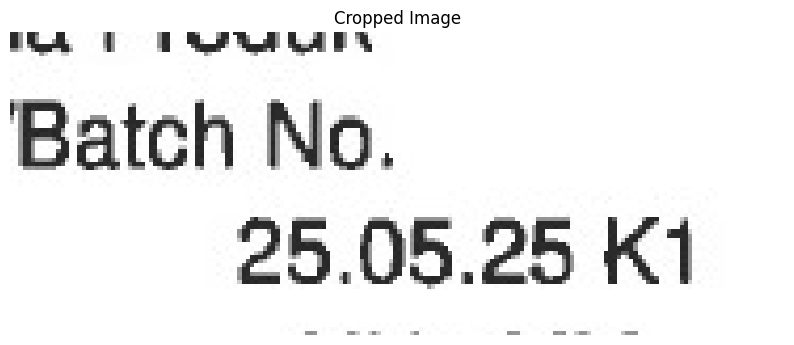

In [10]:
# Find contours in the mask
contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Find the largest contour
largest_contour = max(contours, key=cv2.contourArea)

# Get the bounding box of the largest contour
x, y, w, h = cv2.boundingRect(largest_contour)

# Crop the image using the bounding box
cropped_image = image_rgb[y:y+h, x:x+w]

# Show the cropped image
plt.figure(figsize=(10, 10))
plt.imshow(cropped_image)
plt.title("Cropped Image")
plt.axis('off')
plt.show()


# BOX (KARDUS)

## Pytesseract

In [11]:

def process_image(image_path):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    kernel_size = 3
    max_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (kernel_size, kernel_size))

    blur_image = cv2.GaussianBlur(image, (7, 7), 0)
    denoised_image = cv2.fastNlMeansDenoising(blur_image, None, 15, 7, 21)
    more_denoised = cv2.medianBlur(denoised_image, 9)

    # Thresholding
    thresh = cv2.adaptiveThreshold(
        more_denoised,
        maxValue=255,
        adaptiveMethod=cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
        thresholdType=cv2.THRESH_BINARY_INV,
        blockSize=29,
        C=2
    )

    # Parameters for iteration
    dilate_iterations_range = range(4, 7)
    erode_iterations_range = range(1, 6)
    closing_kernel_sizes = [(1, 1), (3, 3), (5, 5)]

    best_confidence = -1
    best_image = None
    best_dilate_iter = None
    best_erode_iter = None
    best_closing_kernel = None
    best_confidence_data = []

    for dilate_iter in dilate_iterations_range:
        # Dilate
        dilate = cv2.dilate(thresh, max_kernel, iterations=dilate_iter)

        for erode_iter in erode_iterations_range:
            # Erode
            erode = cv2.erode(dilate, max_kernel, iterations=erode_iter)

            for closing_kernel_size in closing_kernel_sizes:
                # Closing (Dilation followed by Erosion)
                closing_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, closing_kernel_size)
                closed = cv2.morphologyEx(erode, cv2.MORPH_CLOSE, closing_kernel)

                # Use pytesseract to extract text and data with confidence scores
                custom_config = r'--oem 3 --psm 6'
                data = pytesseract.image_to_data(closed, config=custom_config, output_type=Output.DICT)

                # Filter out text with confidence scores above 50
                res = []
                for i in range(len(data['text'])):
                    if float(data['conf'][i]) > 50:
                        res.append((data['text'][i], float(data['conf'][i])))
                    if len(res) >= 2:
                        break

                if len(res) == 2:
                    avg_confidence = (res[0][1] + res[1][1]) / 2

                    if avg_confidence > best_confidence:
                        best_confidence = avg_confidence
                        best_image = closed
                        best_dilate_iter = dilate_iter
                        best_erode_iter = erode_iter
                        best_closing_kernel = closing_kernel_size
                        best_confidence_data = res

    # Connected component analysis to get individual character bounding boxes
    num_labels, labels_im = cv2.connectedComponents(best_image)
    best_image_color = cv2.cvtColor(best_image, cv2.COLOR_GRAY2BGR)

    padding = 10  # Define your desired padding size here
    for label in range(1, num_labels):  # Skip the background
        mask = labels_im == label
        coords = cv2.findNonZero(mask.astype(np.uint8))
        x, y, w, h = cv2.boundingRect(coords)
        x1 = max(x - padding, 0)
        y1 = max(y - padding, 0)
        x2 = min(x + w + padding, best_image.shape[1])
        y2 = min(y + h + padding, best_image.shape[0])
        if w >= 30:  # Exclude characters with width below 30
            char_img = best_image[y1:y2, x1:x2]
            char_text = pytesseract.image_to_string(char_img, config='--psm 10 outputbase digits')
            print(f"CHAR TEXT {char_text}")
            cv2.rectangle(best_image_color, (x1, y1), (x2, y2), (0, 255, 0), 2)
            cv2.putText(best_image_color, f'{char_text}', (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)


    print(f"Best Dilate Iterations: {best_dilate_iter}")
    print(f"Best Erode Iterations: {best_erode_iter}")
    print(f"Best Closing Kernel Size: {best_closing_kernel}")
    print("\nBest Confidence Scores:")

    if len(best_confidence_data) > 0:
        print(f"Word 1: {best_confidence_data[0][0]}, Confidence: {best_confidence_data[0][1]}%")
    else:
        print("Word 1: Not available")

    if len(best_confidence_data) > 1:
        print(f"Word 2: {best_confidence_data[1][0]}, Confidence: {best_confidence_data[1][1]}%")
    else:
        print("Word 2: Not available")

    # Display the best preprocessed image with rectangles
    if best_image is not None:
        plt.figure(figsize=(15, 7))
        plt.title('Best Preprocessed Image with Rectangles')
        plt.imshow(cv2.cvtColor(best_image_color, cv2.COLOR_BGR2RGB))
        plt.show()
    else:
        print("No suitable image found")


CHAR TEXT 
CHAR TEXT 9

CHAR TEXT 9

CHAR TEXT 
CHAR TEXT 
CHAR TEXT 5

CHAR TEXT 4

CHAR TEXT 5

CHAR TEXT 
CHAR TEXT 5

CHAR TEXT 
CHAR TEXT -

CHAR TEXT 1

Best Dilate Iterations: 4
Best Erode Iterations: 4
Best Closing Kernel Size: (1, 1)

Best Confidence Scores:
Word 1: 19.84.25, Confidence: 89.0%
Word 2: K4, Confidence: 82.0%


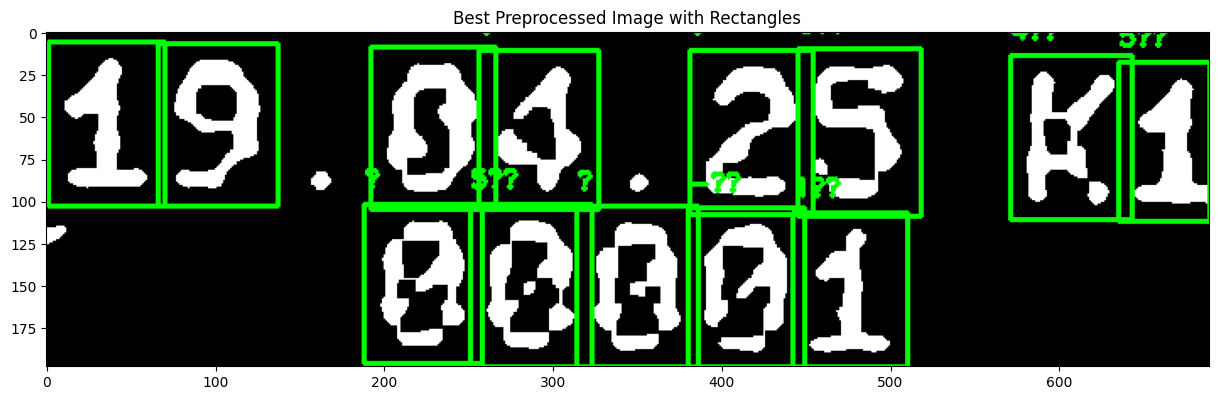

CHAR TEXT 
CHAR TEXT 
CHAR TEXT 
CHAR TEXT 3

CHAR TEXT 8

CHAR TEXT 2

CHAR TEXT 2

CHAR TEXT 
CHAR TEXT 
CHAR TEXT 
CHAR TEXT 
CHAR TEXT 
CHAR TEXT 4

CHAR TEXT 
Best Dilate Iterations: 4
Best Erode Iterations: 2
Best Closing Kernel Size: (1, 1)

Best Confidence Scores:
Word 1: 49.93.25, Confidence: 90.0%
Word 2: K2, Confidence: 80.0%


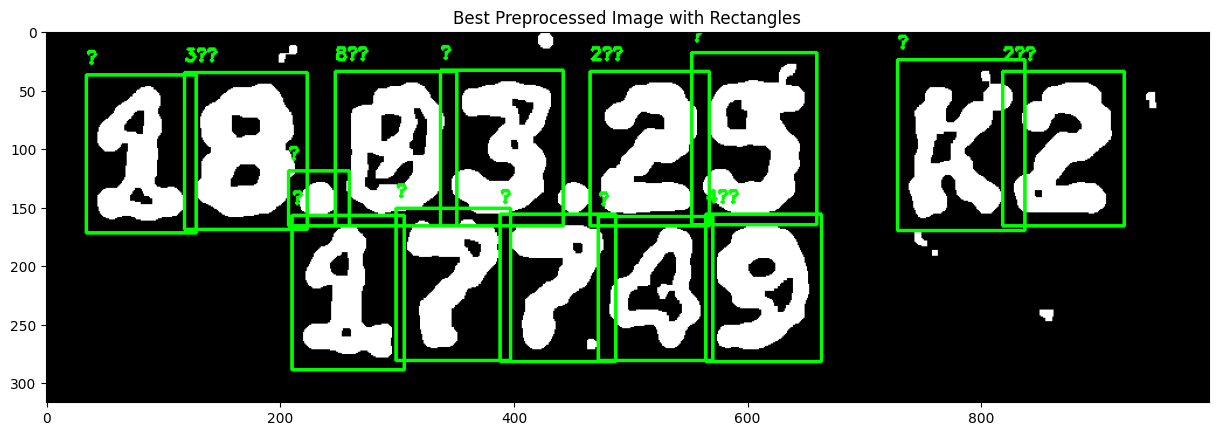

CHAR TEXT 
CHAR TEXT 4

CHAR TEXT 
CHAR TEXT 5

CHAR TEXT 
CHAR TEXT 
CHAR TEXT 2

CHAR TEXT 4

CHAR TEXT 
CHAR TEXT 
CHAR TEXT 5

CHAR TEXT 
CHAR TEXT 
CHAR TEXT 
CHAR TEXT 
Best Dilate Iterations: 6
Best Erode Iterations: 3
Best Closing Kernel Size: (1, 1)

Best Confidence Scores:
Word 1: 24.83.25, Confidence: 89.0%
Word 2: Ki, Confidence: 96.0%


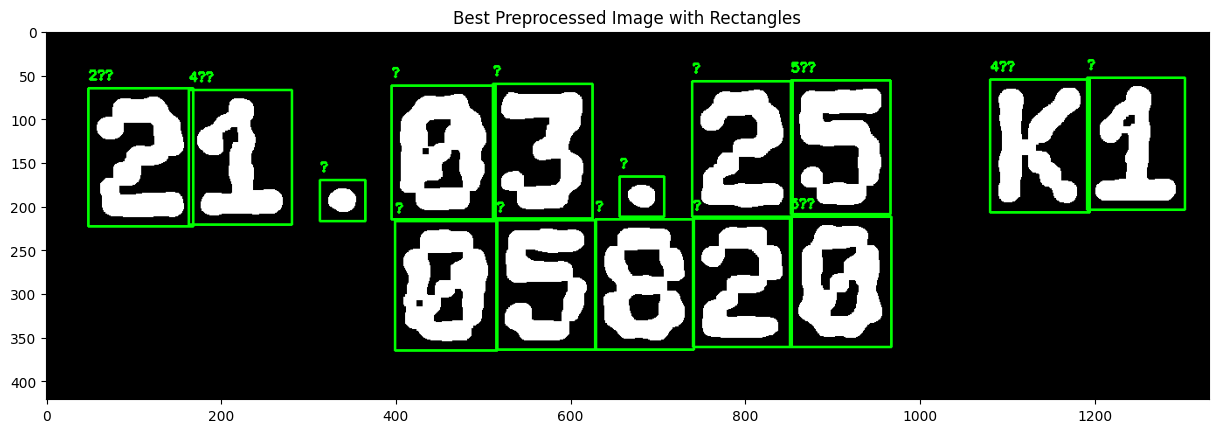

CHAR TEXT 4

CHAR TEXT 5

CHAR TEXT 
CHAR TEXT 
CHAR TEXT 
CHAR TEXT 
CHAR TEXT 
CHAR TEXT 
CHAR TEXT 
CHAR TEXT 
CHAR TEXT 4

CHAR TEXT 8

CHAR TEXT 
CHAR TEXT 
CHAR TEXT 
Best Dilate Iterations: 6
Best Erode Iterations: 1
Best Closing Kernel Size: (1, 1)

Best Confidence Scores:
Word 1: 24.83.25, Confidence: 67.0%
Word 2: Ki, Confidence: 95.0%


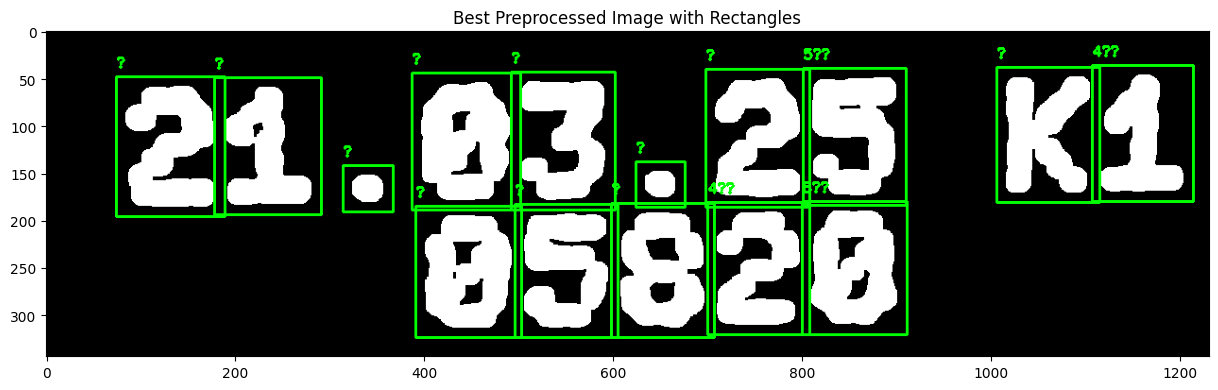

CHAR TEXT 3

CHAR TEXT 
CHAR TEXT 
CHAR TEXT 4

CHAR TEXT 2

CHAR TEXT 4

CHAR TEXT 
CHAR TEXT 
CHAR TEXT 
CHAR TEXT 0

CHAR TEXT 
CHAR TEXT 
CHAR TEXT 
Best Dilate Iterations: 4
Best Erode Iterations: 4
Best Closing Kernel Size: (1, 1)

Best Confidence Scores:
Word 1: 48.93.23, Confidence: 81.0%
Word 2: K2, Confidence: 83.0%


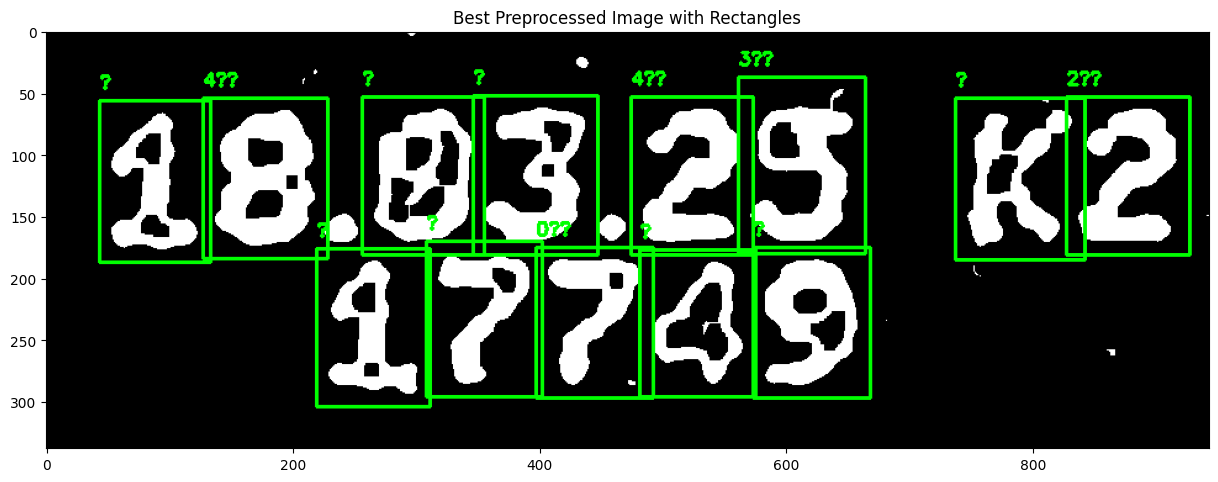

CHAR TEXT 4

CHAR TEXT 4

CHAR TEXT 
CHAR TEXT 3

CHAR TEXT 2

CHAR TEXT 
CHAR TEXT 
CHAR TEXT 
CHAR TEXT 
CHAR TEXT 
CHAR TEXT 
CHAR TEXT 6

CHAR TEXT 
Best Dilate Iterations: 6
Best Erode Iterations: 3
Best Closing Kernel Size: (1, 1)

Best Confidence Scores:
Word 1: 28.83.23, Confidence: 84.0%
Word 2: Ki, Confidence: 89.0%


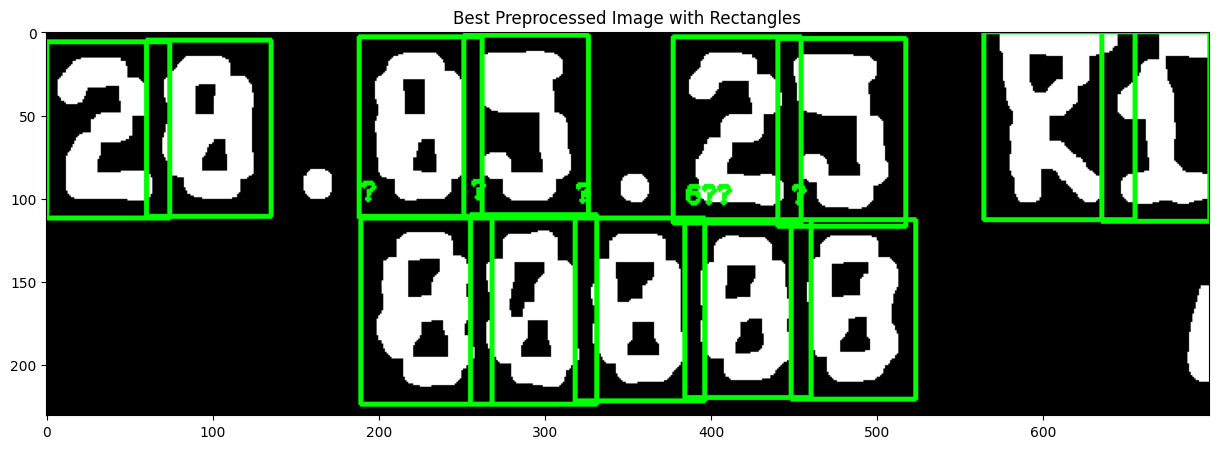

In [12]:
photos_path = '/content/drive/MyDrive/production-ocr-dataset/kardus'
photo_files = [f for f in os.listdir(photos_path) if os.path.isfile(os.path.join(photos_path, f))]

for photo in photo_files:
    photo_path = os.path.join(photos_path, photo)
    process_image(photo_path);


## Easy OCR

In [13]:
!pip install easyocr

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 10.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 908.3/908.3 kB 54.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 307.2/307.2 kB 28.6 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manyl

In [14]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import easyocr

def preprocess_image(image_path):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    blur_image = cv2.GaussianBlur(image, (7, 7), 0)
    denoised_image = cv2.fastNlMeansDenoising(blur_image, None, 15, 7, 21)
    more_denoised = cv2.medianBlur(denoised_image, 9)

    thresh = cv2.adaptiveThreshold(
        more_denoised,
        maxValue=255,
        adaptiveMethod=cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
        thresholdType=cv2.THRESH_BINARY_INV,
        blockSize=29,
        C=2
    )

    return thresh

def find_best_preprocessing(image):
    kernel_size = 3
    max_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (kernel_size, kernel_size))

    dilate_iterations_range = range(4, 7)
    erode_iterations_range = range(1, 6)
    closing_kernel_sizes = [(1, 1), (3, 3), (5, 5)]

    best_image = None

    reader = easyocr.Reader(['en'])  # Initialize EasyOCR reader

    best_confidence = -1
    best_image = None
    best_dilate_iter = None
    best_erode_iter = None
    best_closing_kernel = None
    best_confidence_data = []

    for dilate_iter in dilate_iterations_range:
        dilate = cv2.dilate(image, max_kernel, iterations=dilate_iter)
        for erode_iter in erode_iterations_range:
            erode = cv2.erode(dilate, max_kernel, iterations=erode_iter)
            for closing_kernel_size in closing_kernel_sizes:
                closing_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, closing_kernel_size)
                closed = cv2.morphologyEx(erode, cv2.MORPH_CLOSE, closing_kernel)

                custom_config = r'--oem 3 --psm 6'
                data = pytesseract.image_to_data(closed, config=custom_config, output_type=Output.DICT)

                res = []
                for i in range(len(data['text'])):
                    if float(data['conf'][i]) > 50:
                        res.append((data['text'][i], float(data['conf'][i])))
                    if len(res) >= 2:
                        break

                if len(res) == 2:
                    avg_confidence = (res[0][1] + res[1][1]) / 2

                    if avg_confidence > best_confidence:
                        best_confidence = avg_confidence
                        best_image = closed
                        best_dilate_iter = dilate_iter
                        best_erode_iter = erode_iter
                        best_closing_kernel = closing_kernel_size
                        best_confidence_data = res

    ocr_result = reader.readtext(best_image, detail=0)
    print("RAW OCR Result: ", ocr_result)
    # Join all the elements of the array result
    ocr_result = ''.join(ocr_result)
    print("Joined OCR Result: ", ocr_result)

    # Remove special characters (in this case, ".")
    ocr_result = ocr_result.replace(" ", "").replace(".", "")
    print("Special Characters Removed: ", ocr_result)

    # Add a dot after every 2 characters for the first 6 characters (21.03.25)
    formatted_result = '.'.join(ocr_result[i:i+2] for i in range(0, 6, 2))
    print("Formatted Result: ", formatted_result)

    # Concatenate the remaining part, replacing 'K1' with 'K2'
    formatted_result = f"{formatted_result} {ocr_result[6:8]} {ocr_result[8:]}"
    print("Final Result: ", formatted_result)
    return best_image

def draw_bounding_boxes(image, reader):
    num_labels, labels_im = cv2.connectedComponents(image)
    image_color = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
    padding = 12

    for label in range(1, num_labels):
        mask = labels_im == label
        coords = cv2.findNonZero(mask.astype(np.uint8))
        x, y, w, h = cv2.boundingRect(coords)
        x1 = max(x - padding, 0)
        y1 = max(y - padding, 0)
        x2 = min(x + w + padding, image.shape[1])
        y2 = min(y + h + padding, image.shape[0])

        if w >= 30:
            char_img = image[y1:y2, x1:x2]
            results = reader.readtext(char_img, detail=0)
            if results:
                text = results[0]
                print(text)
                cv2.rectangle(image_color, (x1, y1), (x2, y2), (0, 255, 0), 2)
                cv2.putText(image_color, text, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

    return image_color

def process_image(image_path):
    preprocessed_image = preprocess_image(image_path)
    best_image = find_best_preprocessing(preprocessed_image)

    if best_image is not None:
        reader = easyocr.Reader(['en'])
        final_image = draw_bounding_boxes(best_image, reader)
        plt.figure(figsize=(15, 7))
        plt.title('Best Preprocessed Image with Bounding Boxes')
        plt.imshow(cv2.cvtColor(final_image, cv2.COLOR_BGR2RGB))
        plt.show()
    else:
        print("No suitable image found")


Progress: |██████████████████████████████████████████████████| 100.0% Complete

Progress: |██████████████████████████████████████████████████| 100.0% Complete

RAW OCR Result:  ['19', '04.25', 'KL', '000Q1']
Joined OCR Result:  1904.25KL000Q1
Special Characters Removed:  190425KL000Q1
Formatted Result:  19.04.25
Final Result:  19.04.25 KL 000Q1
1
9
$
2
5
1
0
9
1


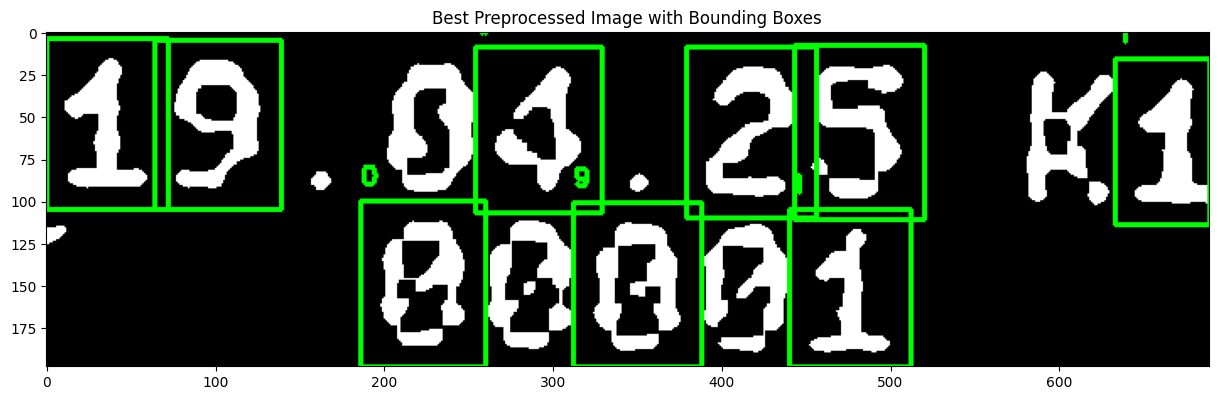

RAW OCR Result:  ['18.03.25', 'K2', '17749']
Joined OCR Result:  18.03.25K217749
Special Characters Removed:  180325K217749
Formatted Result:  18.03.25
Final Result:  18.03.25 K2 17749
5
K
3
8
0
2
2
4
7
1
7
9
4


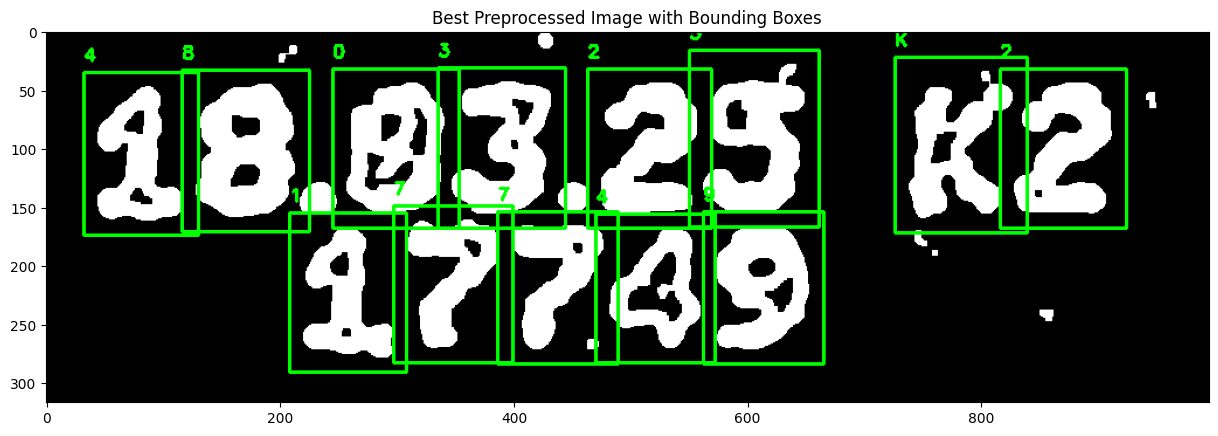

RAW OCR Result:  ['21.03', '25', 'K1', '05820']
Joined OCR Result:  21.0325K105820
Special Characters Removed:  210325K105820
Formatted Result:  21.03.25
Final Result:  21.03.25 K1 05820
1
K
2
5
3
0
2
1
0
8
2
0
5


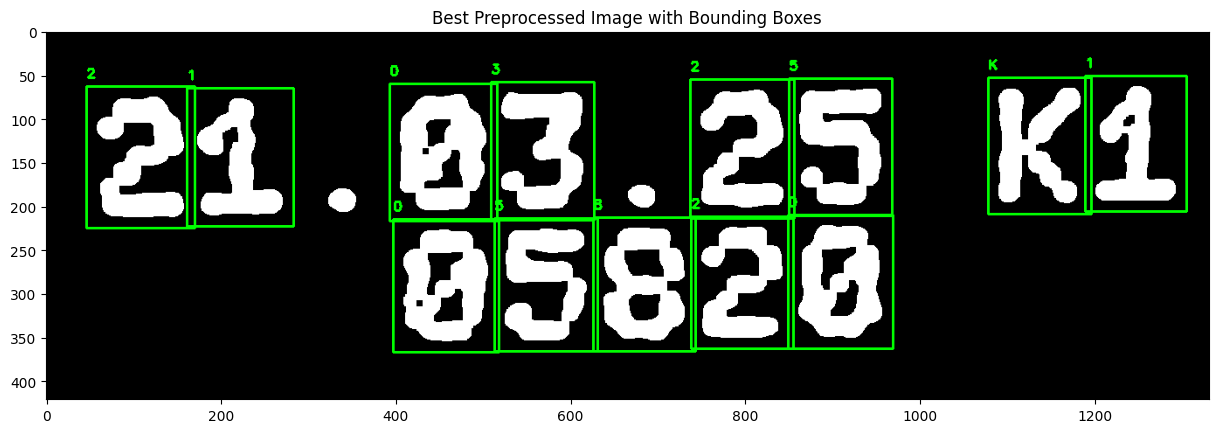

KeyboardInterrupt: 

In [15]:
import os
import cv2
import matplotlib.pyplot as plt

photos_path = '/content/drive/MyDrive/production-ocr-dataset/kardus'
photo_files = [f for f in os.listdir(photos_path) if os.path.isfile(os.path.join(photos_path, f))]

for photo in photo_files:
    photo_path = os.path.join(photos_path, photo)
    process_image(photo_path);


# CAP

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import easyocr

def preprocess_image(image_path):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    blur_image = cv2.GaussianBlur(image, (7, 7), 0)
    denoised_image = cv2.fastNlMeansDenoising(blur_image, None, 15, 7, 21)
    more_denoised = cv2.medianBlur(denoised_image, 9)

    thresh = cv2.adaptiveThreshold(
        more_denoised,
        maxValue=255,
        adaptiveMethod=cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
        thresholdType=cv2.THRESH_BINARY_INV,
        blockSize=29,
        C=2
    )

    return thresh

def find_best_preprocessing(image):
    kernel_size = 3
    max_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (kernel_size, kernel_size))

    dilate_iterations_range = range(4, 7)
    erode_iterations_range = range(1, 6)
    closing_kernel_sizes = [(1, 1), (3, 3), (5, 5)]

    best_image = None

    reader = easyocr.Reader(['en'])  # Initialize EasyOCR reader

    best_confidence = -1
    best_image = None
    best_dilate_iter = None
    best_erode_iter = None
    best_closing_kernel = None
    best_confidence_data = []

    for dilate_iter in dilate_iterations_range:
        dilate = cv2.dilate(image, max_kernel, iterations=dilate_iter)
        for erode_iter in erode_iterations_range:
            erode = cv2.erode(dilate, max_kernel, iterations=erode_iter)
            for closing_kernel_size in closing_kernel_sizes:
                closing_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, closing_kernel_size)
                closed = cv2.morphologyEx(erode, cv2.MORPH_CLOSE, closing_kernel)

                custom_config = r'--oem 3 --psm 6'
                data = pytesseract.image_to_data(closed, config=custom_config, output_type=Output.DICT)

                res = []
                for i in range(len(data['text'])):
                    if float(data['conf'][i]) > 50:
                        res.append((data['text'][i], float(data['conf'][i])))
                    if len(res) >= 2:
                        break

                if len(res) == 2:
                    avg_confidence = (res[0][1] + res[1][1]) / 2

                    if avg_confidence > best_confidence:
                        best_confidence = avg_confidence
                        best_image = closed
                        best_dilate_iter = dilate_iter
                        best_erode_iter = erode_iter
                        best_closing_kernel = closing_kernel_size
                        best_confidence_data = res

                # Visualize dilate, erode, and closed images
                plt.figure(figsize=(15, 5))
                plt.subplot(1, 3, 1)
                plt.title(f'Dilate (iter={dilate_iter})')
                plt.imshow(dilate, cmap='gray')
                plt.subplot(1, 3, 2)
                plt.title(f'Erode (iter={erode_iter})')
                plt.imshow(erode, cmap='gray')
                plt.subplot(1, 3, 3)
                plt.title(f'Closed (kernel={closing_kernel_size})')
                plt.imshow(closed, cmap='gray')
                plt.show()

    ocr_result = reader.readtext(best_image, detail=0)
    print("RAW OCR Result: ", ocr_result)
    # Join all the elements of the array result
    ocr_result = ''.join(ocr_result)
    print("Joined OCR Result: ", ocr_result)

    # Remove special characters (in this case, ".")
    ocr_result = ocr_result.replace(" ", "").replace(".", "")
    print("Special Characters Removed: ", ocr_result)

    # Add a dot after every 2 characters for the first 6 characters (21.03.25)
    formatted_result = '.'.join(ocr_result[i:i+2] for i in range(0, 6, 2))
    print("Formatted Result: ", formatted_result)

    # Concatenate the remaining part, replacing 'K1' with 'K2'
    formatted_result = f"{formatted_result} {ocr_result[6:8]} {ocr_result[8:]}"
    print("Final Result: ", formatted_result)
    return best_image

def draw_bounding_boxes(image, reader):
    num_labels, labels_im = cv2.connectedComponents(image)
    image_color = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
    padding = 12

    for label in range(1, num_labels):
        mask = labels_im == label
        coords = cv2.findNonZero(mask.astype(np.uint8))
        x, y, w, h = cv2.boundingRect(coords)
        x1 = max(x - padding, 0)
        y1 = max(y - padding, 0)
        x2 = min(x + w + padding, image.shape[1])
        y2 = min(y + h + padding, image.shape[0])

        if w >= 30:
            char_img = image[y1:y2, x1:x2]
            results = reader.readtext(char_img, detail=0)
            if results:
                text = results[0]
                print(text)
                cv2.rectangle(image_color, (x1, y1), (x2, y2), (0, 255, 0), 2)
                cv2.putText(image_color, text, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

    return image_color

def process_image(image_path):
    preprocessed_image = preprocess_image(image_path)
    best_image = find_best_preprocessing(preprocessed_image)

    if best_image is not None:
        reader = easyocr.Reader(['en'])
        final_image = draw_bounding_boxes(best_image, reader)
        plt.figure(figsize=(15, 7))
        plt.title('Best Preprocessed Image with Bounding Boxes')
        plt.imshow(cv2.cvtColor(final_image, cv2.COLOR_BGR2RGB))
        plt.show()
    else:
        print("No suitable image found")


In [ ]:
import os
import cv2
import matplotlib.pyplot as plt

photos_path = '/content/drive/MyDrive/production-ocr-dataset/CAP'
photo_files = [f for f in os.listdir(photos_path) if os.path.isfile(os.path.join(photos_path, f))]

for photo in photo_files:
    photo_path = os.path.join(photos_path, photo)
    process_image(photo_path);
